# Molecular Similarity Search
In this example, we try to do similarity retrieval of molecular formulae by generating molecular fingerprints using RDKit, and then search them in Milvus to finally return the most similar result to the target molecular formula.

## Data
We already prepared a SMILE file containing 10,000 molecular formula [test_1w.smi](./smiles-data) form [pubchem](ftp://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF). The file content has two columns, SMILES and ID, such as the following:  
[O-]C(=O)CC(C[N+](C)(C)C)OC(=O)C	1  
OC(=O)CC(C[N+](C)(C)C)OC(=O)C	2  
OC1C=CC=C(C1O)C(=O)O	3  
CC(CN)O	4  
NCC(=O)COP(=O)(O)O	5

Before running this notebook, you need to install [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) or [miniconda](https://docs.conda.io/en/latest/miniconda.html) locally, because we will use conda to install [RDKit](https://www.rdkit.org/docs/Install.html), then activate a new conda environment to run this notebook. Note that python version cannot above 3.8, my environment is python3.7.

## Requirements
#### 1. Install RDkit
Install RDKit with Conda.

In [ ]:
! conda install -c rdkit rdkit -y

#### 2. Install python packages
Install the required python package with "requirements.txt".

In [10]:
! pip install -r requirements.txt

## Start Milvus
Start Docker container witout mapping the files, if you want to map the paths to the local files to the container, you can refer to [Install and Start Milvus](https://milvus.io/docs/v1.0.0/milvus_docker-cpu.md).

In [21]:
! docker run -d \
-p 19530:19530 \
-p 19121:19121 \
milvusdb/milvus:1.1.0-cpu-d050721-5e559c

Unable to find image 'milvusdb/milvus:1.1.0-cpu-d050721-5e559c' locally
1.1.0-cpu-d050721-5e559c: Pulling from milvusdb/milvus

3b07cdd5: Pulling fs layer 
21c63ac5: Pulling fs layer 
a14988df: Pulling fs layer 
Digest: sha256:cad42699d1c0943fa618eb6d293eb28b2e223fd1410a83717f81b0d5c7698059[2ADownloading  34.21MB/146MBDownloading  43.33MB/146MBDownloading  71.72MB/76.1MBDownloading  92.59MB/146MB
Status: Downloaded newer image for milvusdb/milvus:1.1.0-cpu-d050721-5e559c
19989220e7464a2e288779bb28345b6b6ecceab2bfc9a18a7097ef6dcbdd914c


## Start MySQL
MySQL is used to store the molecular formula and id, which support quickly search the molecular corresponding to the id.

In [19]:
! docker run -p 3306:3306 -e MYSQL_ROOT_PASSWORD=123456 -d mysql:5.7

f7018a98a095d261163ed22509fb7dde72a51d60235dc1ce13ed93a6e9f12718


## Running code
After preparing the conda environment (installing RDKit, etc.) and successfully starting Milvus and MySQL, we will start processing the molecular formula data, storing it in Milvus and do similarity searches.

#### 1. Connect the server
We first connect to the servers. In this case the docker containers are running on localhost and the ports are the default ports.

In [21]:
# connect to the Milvus and MySQL server.
from milvus import *
import pymysql

milvus = Milvus(host='localhost', port='19530')
conn = pymysql.connect(host='localhost', user='root', port=3306, password='123456', db='mysql', local_infile=True)
cursor = conn.cursor()

#### 2. Generate molecular fingerprint with RDKit
Before run the following code, we declare some variables, such as the dimension of the vector, the name of the collection/table, the path of the SMILES file and the target SMILES molecular.

In [53]:
VECTOR_DIMENSION = 512
collection_name = 'mol_search'
file_path = './smiles-data/test_1w.smi'
target_smiles = 'Cc1ccc(cc1)S(=O)(=O)N'

We can use RDKit to generate Morgan fingerprints, which defines a radius from a specific atom and calculates the number of chemical structures within the range of the radius to generate a chemical fingerprint. Specify different values for the radius and bits to acquire the chemical fingerprints of different chemical structures. The molecular formula are represented in SMILES format.

In [23]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

def smiles_to_vec(smiles):
    mols = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mols, 2, VECTOR_DIMENSION)
    hex_fp = DataStructs.BitVectToFPSText(fp)
    vec = bytes.fromhex(hex_fp)
    return vec

#### 3. Create the Milvus collection 
The next step is to create the collection in Milvus in order to store and retireval the molecular fingerprints. We need to specify the parameter `collection_name`, `dimension`, `index_file_size` and `metric_type` when creating.

In [41]:
collection_param = {
     "collection_name": collection_name,
     "dimension": VECTOR_DIMENSION,
     "index_file_size": 2048,
     "metric_type": MetricType.JACCARD
}
status, ok = milvus.has_collection(collection_name)

if not ok:
    milvus.create_collection(collection_param)

#### 4. Load the molecular fingerprint to Milvus
Then we can then read the SMILES file and batch insert it into Milvus.

In [24]:
# get all the fingerprint in the file
def get_vectors(file_path):
    ids = []
    vectors = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip().split()
            smiles = line[0]
            num = int(line[1])
            vec = smiles_to_vec(smiles)
            vectors.append(vec)
            ids.append(num)
    return vectors, ids

In [32]:
# batch insert the fingerprint to Milvus
vectors, ids = get_vectors(file_path)
status, mids = milvus.insert(collection_name, vectors, ids)
print(status, len(mids))

#### 5. Load the SMILES file to MySQL
We have successfully stored the molecular fingerprints and ids in Milvus, next we will load the SMILES and ids in MySQL, the reason is that Milvus v1.1 does not support scalar filtering yet (2.0 will support it), and the query result will only return ids, so we need MySQL to store and search the returned ids corresponding to the SMILES.

In [20]:
# create the table in MySQL
def create_table_mysql(conn, cursor, table_name):
    sql = "create table if not exists " + table_name + "(smiles varchar(256), ids bigint);"
    try:
        cursor.execute(sql)
        conn.commit()
    except Exception as e:
        print("MYSQL ERROR:", e, sql)

# load the local file to MySQL
def load_data_mysql(conn, cursor, table_name, file_path):
    sql = "load data local infile '" + file_path + "' into table " + table_name + ";"
    try:
        cursor.execute(sql)
        conn.commit()
    except Exception as e:
        print("MYSQL ERROR:", e, sql)

In [ ]:
create_table_mysql(conn, cursor, collection_name)
load_data_mysql(conn, cursor, collection_name, file_path)

#### 6. Search the similarity molecular 
After load the data, we can do the similarity search. First convert the SMILES into molecular fingerprints and then retrieved in Milvus. Milvus will return similar ids and distances, and then get the SMILES in MySQL according to the result ids.

In [63]:
# get the similar results(ids and distance) with the target smiles in Milvus
def search_in_milvus(collection_name, smiles, top_k):
    vec = smiles_to_vec(smiles)
    status, vectors = milvus.search(collection_name, top_k, [vec], params={"metric_type": MetricType.JACCARD})
    print(status)
    re_ids = [x.id for x in vectors[0]]
    re_distance = [x.distance for x in vectors[0]]

    return re_ids, re_distance

In [64]:
# get the smiles according the result ids
def search_by_milvus_id(conn, cursor, collection_name, ids):
    str_ids = str(ids).replace('[','').replace(']','')
    sql = "select smiles from " + collection_name + " where ids in (" + str_ids + ") order by field (ids, " + str_ids + ");"
    try:
        cursor.execute(sql)
        results = cursor.fetchall()
        results = [res[0] for res in results]
        return results
    except Exception as e:
        print("MYSQL ERROR:", e, sql)

In [65]:
re_ids, re_distance = search_in_milvus(collection_name, target_smiles, 5)
re_smiles = search_by_milvus_id(conn, cursor, collection_name, re_ids)
print(re_smiles, re_ids, re_distance)

Status(code=0, message='Search vectors successfully!')
['Cc1ccc(cc1)S(=O)(=O)N', 'Cc1ccc(cc1)S(=O)(=O)Cl', 'Nc1ccc(cc1)S(=O)(=O)N', 'Cc1ccc(cc1)S(=O)(=O)F', 'Cc1ccc(cc1)S(=O)(=O)O'] [6269, 7397, 5333, 9965, 6101] [0.0, 0.3636363744735718, 0.40909090638160706, 0.43478259444236755, 0.43478259444236755]


#### 7. Show the results
Finally we get the top five results that are most similar to the target SMILES('Cc1ccc(cc1)S(=O)(=O)N'), and we can also visualize the results.

In [28]:
from rdkit.Chem import Draw
def draw_smiles(smiles):
    mols = Chem.MolFromSmiles(smiles)
    img = Draw.MolsToGridImage([mols], molsPerRow=1, subImgSize=(150, 150))
    return img

target-smiles: Cc1ccc(cc1)S(=O)(=O)N


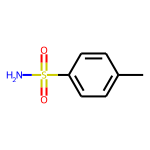

In [31]:
# show the target smiles
img = draw_smiles(target_smiles)
print("target-smiles:", target_smiles)
display(img)

Cc1ccc(cc1)S(=O)(=O)N 	ids: 6269 	distance: 0.0


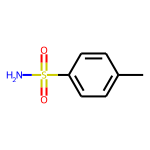

Cc1ccc(cc1)S(=O)(=O)Cl 	ids: 7397 	distance: 0.3636363744735718


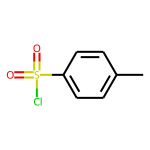

Nc1ccc(cc1)S(=O)(=O)N 	ids: 5333 	distance: 0.40909090638160706


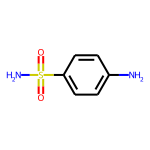

Cc1ccc(cc1)S(=O)(=O)F 	ids: 9965 	distance: 0.43478259444236755


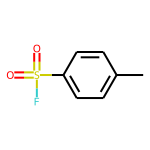

Cc1ccc(cc1)S(=O)(=O)O 	ids: 6101 	distance: 0.43478259444236755


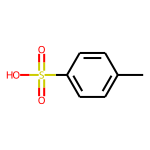

In [35]:
# show the tok5 similar molecules 
for s, i, d in zip(re_smiles,re_ids, re_distance):
    print(s, "\tids:", i, "\tdistance:", d)
    display(draw_smiles(s))

## Conclusion
This notebook shows how to search the similar molecular, we can also saerch the superstructure and substructure with the different [METRICS](https://milvus.io/docs/v1.1.0/metric.md#floating) when search in Milvus.

We have also built the demo system (https://milvus.io/scenarios), and we also have an open source projects on substructure and superstructure search in [MolSearch](https://github.com/zilliztech/MolSearch), so you are welcome to try it yourself and search your own molecular.